In [96]:
import os
import math
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report ,confusion_matrix
from pathlib import Path
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D, Concatenate, Reshape, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
tf.random.set_seed(42)

In [97]:
# print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [98]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)


In [99]:
class DataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_size = (460, 460)
        self.label_encoder = None
    
    def apply_augmentation(self, image, bbox):
        bbox = tf.cast(bbox, tf.float32)
        
        h, w = float(self.image_size[0]), float(self.image_size[1])
        bbox_pixel = bbox * tf.constant([w, h, w, h], dtype=tf.float32)
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            bbox_pixel = tf.stack([
                w - bbox_pixel[2],
                bbox_pixel[1],    
                w - bbox_pixel[0], 
                bbox_pixel[3]      
            ])
        
        if tf.random.uniform([]) > 0.5:
            angle = tf.random.uniform([], minval=-15, maxval=15) * math.pi / 180
            image = tf.keras.layers.RandomRotation(
                factor=(-15/360, 15/360),
                fill_mode='constant',
                fill_value=1.0
            )(image)
            
            center_x = (bbox_pixel[0] + bbox_pixel[2]) / 2
            center_y = (bbox_pixel[1] + bbox_pixel[3]) / 2
            width = bbox_pixel[2] - bbox_pixel[0]
            height = bbox_pixel[3] - bbox_pixel[1]
            
            cos_theta = tf.cos(angle)
            sin_theta = tf.sin(angle)
            new_center_x = (center_x - w/2) * cos_theta - (center_y - h/2) * sin_theta + w/2
            new_center_y = (center_x - w/2) * sin_theta + (center_y - h/2) * cos_theta + h/2
            
            expansion_factor = 1.2
            new_width = width * expansion_factor
            new_height = height * expansion_factor
            
            bbox_pixel = tf.stack([
                tf.clip_by_value(new_center_x - new_width/2, 0, w),
                tf.clip_by_value(new_center_y - new_height/2, 0, h),
                tf.clip_by_value(new_center_x + new_width/2, 0, w),
                tf.clip_by_value(new_center_y + new_height/2, 0, h)
            ])
        
        if tf.random.uniform([]) > 0.5:
            zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.0)
            image = tf.image.central_crop(image, zoom_factor)
            image = tf.image.resize(image, self.image_size)
            
            bbox_pixel = bbox_pixel * zoom_factor
            bbox_pixel = tf.clip_by_value(bbox_pixel, 0, tf.maximum(w, h))
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)
        
        if tf.random.uniform([]) > 0.5:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        
        bbox = bbox_pixel / tf.constant([w, h, w, h], dtype=tf.float32)
        return image, bbox

    def load_and_preprocess_image(self, filename, label, bbox):
        try:
            img = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.image_size)
            img = tf.cast(img, tf.float32) / 255.0
            
            img, bbox = self.apply_augmentation(img, bbox)
            
            return img, label, bbox
        except tf.errors.NotFoundError:
            tf.print(f"File not found: {filename}")
            return None, None, None
            
    def create_dataset(self, csv_file, base_dir, is_training=True, batch_size=32):
        df = pd.read_csv(csv_file)
        
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            df['class'] = self.label_encoder.fit_transform(df['class'])
        else:
            df['class'] = self.label_encoder.transform(df['class'])
            
        filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
        labels = df['class'].values
        #labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))
        
        bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
        
        bboxes = bboxes / np.array([self.image_size[1], self.image_size[0], 
                                   self.image_size[1], self.image_size[0]], 
                                   dtype=np.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels, bboxes))
        dataset = dataset.map(
            lambda f, l, b: (self.load_and_preprocess_image(f, l, b)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.filter(lambda x, y, z: x is not None)
        
        def prepare_data(img, label, bbox):
            return img, {'class_output': label, 'bbox_output': bbox}
        
        dataset = dataset.map(prepare_data)
        
        if is_training:
            dataset = dataset.shuffle(buffer_size=1000)
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        
        return dataset


In [100]:
class VisionModel:
    def __init__(self, num_classes=2, confidence_threshold=0.5):
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(460, 460, 3))
        
        # Initial paths
        # After stride 2: 230x230x16 for each path
        path1 = Conv2D(16, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
        path1 = BatchNormalization()(path1)
        path1 = LeakyReLU(alpha=0.1)(path1)
        
        path2 = Conv2D(16, (5, 5), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
        path2 = BatchNormalization()(path2)
        path2 = LeakyReLU(alpha=0.1)(path2)
        
        path3 = Conv2D(16, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
        path3 = BatchNormalization()(path3)
        path3 = LeakyReLU(alpha=0.1)(path3)
        
        # Concatenate: 230x230x48
        x = Concatenate()([path1, path2, path3])
        
        # MaxPool: 115x115x48
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # Channel reduction while preserving spatial dimensions
        # All following layers maintain 115x115 spatial dimensions
        x = Conv2D(24, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        
        x = Conv2D(12, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        
        x = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)  # 115x115x3
        
        # VGG16 processing
        # Input: 115x115x3, Output: 3x3x512
        
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(115,115,3))
        for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
            layer.trainable = False
        for layer in base_model.layers:
            if isinstance(layer, Conv2D):
                layer.kernel_initializer = tf.keras.initializers.HeNormal()
        
        x = base_model(x, training=True)
        x = BatchNormalization()(x)
        
        # def conv_block(x, filters):
        #     x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        #     x = BatchNormalization()(x)
        #     x = LeakyReLU(alpha=0.1)(x)
        #     x = MaxPooling2D(pool_size=(2, 2))(x)
        #     x = Dropout(0.3)(x)
        #     return x
  # Custom processing after VGG16
        def conv_block(x, filters, apply_pool=True):
            x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            if apply_pool and x.shape[1] > 1 and x.shape[2] > 1:
                x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Dropout(0.3)(x)
            return x
                    
        #x = conv_block(x, 64)
        #x = conv_block(x, 128)

        # One conv block without pooling since spatial dimensions are already small
        x = conv_block(x, 256, apply_pool=False)  # Maintains 3x3 spatial dimensions
        
        x = GlobalAveragePooling2D()(x)
        
        def fc_block(x, units, dropout_rate=0.5):
            skip = x
            x = Dense(units)(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = Dropout(dropout_rate)(x)
            if skip.shape[-1] == units:
                x = x + skip
            return x
            
        x = fc_block(x, 512, dropout_rate=0.5)
        x = fc_block(x, 256, dropout_rate=0.5)
        
        class_output = Dense(1, activation='sigmoid', name='class_output')(x)
        bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)  
        
        model = Model(inputs=inputs, outputs=[class_output, bbox_output])
        return model
        
    def compile_model(self, learning_rate=0.0001):
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'class_output': 'binary_crossentropy',
                'bbox_output': 'huber'
            },
            loss_weights={'class_output': 1.0, 'bbox_output': 2.0},
            metrics={
                'class_output': [
                    'accuracy',
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')
                ],
                'bbox_output': ['mae', tf.keras.metrics.MeanSquaredError()]
            }
        )

    def predict_with_threshold(self, image, threshold=None):
        if threshold is None:
            threshold = self.confidence_threshold

        # Ensure image has batch dimension
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
            
        # Get model predictions
        class_pred, bbox_pred = self.model.predict(image)
        
        # Get confidence score
        confidence = float(class_pred[0]'''[0]''')
        
        # Initialize result dictionary
        result = {
            'confidence': confidence,
            'bbox': bbox_pred[0].tolist(),  # Convert bbox to list
            'above_threshold': confidence >= threshold,
            'prediction': 'weapon' if confidence >= threshold else 'no_weapon',
            'threshold_used': threshold
        }
        
        return result

    def predict_batch_with_threshold(self, images, threshold=None):
        
        if threshold is None:
            threshold = self.confidence_threshold
            
        # Get model predictions
        class_preds, bbox_preds = self.model.predict(images)
        
        results = []
        for class_pred, bbox_pred in zip(class_preds, bbox_preds):
            confidence = float(class_pred[0])
            
            result = {
                'confidence': confidence,
                'bbox': bbox_pred.tolist(),
                'above_threshold': confidence >= threshold,
                'prediction': 'weapon' if confidence >= threshold else 'no_weapon',
                'threshold_used': threshold
            }
            results.append(result)
            
        return results

    def set_confidence_threshold(self, threshold):
        """Update the confidence threshold"""
        self.confidence_threshold = threshold

    def get_callbacks(self, model_dir='model'):
        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                os.path.join(model_dir, 'model-{epoch:02d}-{val_loss:.2f}.keras'),
                monitor='val_loss',
                save_best_only=True,
                verbose=1,
                save_weights_only=False
            )
        ]
        return callbacks

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1369322180.py, line 140)

In [101]:
def plot_metrics(history, save_path=None):

    metrics = [
        ('loss', 'val_loss', 'Loss'),
        ('class_output_accuracy', 'val_class_output_accuracy', 'Classification Accuracy'),
        ('class_output_auc', 'val_class_output_auc', 'AUC'),
        ('bbox_output_mae', 'val_bbox_output_mae', 'Bounding Box MAE')
    ]
    
    plt.figure(figsize=(15, 10))
    for i, (train_metric, val_metric, title) in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[train_metric], label='Train')
        plt.plot(history.history[val_metric], label='Validation')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(title)
        plt.legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def create_experiment_folder():
    """Create a timestamped folder for the experiment"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    experiment_dir = Path(f'experiments/experiment_{timestamp}')
    experiment_dir.mkdir(parents=True, exist_ok=True)
    
    # Create subdirectories
    (experiment_dir / 'models').mkdir(exist_ok=True)
    (experiment_dir / 'plots').mkdir(exist_ok=True)
    (experiment_dir / 'logs').mkdir(exist_ok=True)
    
    return experiment_dir

def save_training_config(experiment_dir, config):
    """Save training configuration"""
    config_path = experiment_dir / 'training_config.txt'
    with open(config_path, 'w') as f:
        for key, value in config.items():
            f.write(f'{key}: {value}\n')


In [102]:

def train_model(
    base_path='dataset/',
    batch_size=32,
    epochs=100,
    initial_learning_rate=0.0001,
    min_learning_rate=1e-6,
    patience=10,
    confidence_threshold=0.5
):
    # Create experiment directory
    experiment_dir = create_experiment_folder()
    
    # Save training configuration
    config = {
        'batch_size': batch_size,
        'epochs': epochs,
        'initial_learning_rate': initial_learning_rate,
        'min_learning_rate': min_learning_rate,
        'patience': patience,
        'confidence_threshold': confidence_threshold
    }
    save_training_config(experiment_dir, config)
    
    # Initialize data processor and create datasets
    data_processor = DataProcessor(base_path)
    
    train_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'train', '_annotations.csv'),
        os.path.join(base_path, 'train'),
        is_training=True,
        batch_size=batch_size
    )
    
    valid_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'valid', '_annotations.csv'),
        os.path.join(base_path, 'valid'),
        is_training=False,
        batch_size=batch_size
    )
    
    model = VisionModel(
        num_classes=len(data_processor.label_encoder.classes_),
        confidence_threshold=confidence_threshold
    )
    model.compile_model(learning_rate=initial_learning_rate)
        # Setup callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=min_learning_rate,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(experiment_dir, 'models', 'model-{epoch:02d}-{val_loss:.2f}.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
            os.path.join(experiment_dir, 'logs', 'training_log.csv'),
            separator=',',
            append=False
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(experiment_dir, 'logs', 'tensorboard'),
            histogram_freq=1
        )
    ]
    
    # Train model
    print(f"\nStarting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Experiment directory: {experiment_dir}")
    
    history = model.model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        workers=4,
        use_multiprocessing=True
    )
    
    # Save final model
    final_model_path = os.path.join(experiment_dir, 'models', 'final_model.keras')
    model.model.save(final_model_path)
    print(f'Final model saved to: {final_model_path}')
    
    # Plot and save metrics
    plot_metrics(history, save_path=os.path.join(experiment_dir, 'plots', 'training_metrics.png'))
    
    # Save training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(experiment_dir, 'logs', 'training_history.csv'))
    
    # Compute and save validation metrics
    val_loss = min(history.history['val_loss'])
    val_acc = max(history.history['val_class_output_accuracy'])
    
    metrics_summary = {
        'best_val_loss': val_loss,
        'best_val_accuracy': val_acc,
        'total_epochs': len(history.history['loss']),
        'final_learning_rate': float(tf.keras.backend.get_value(model.model.optimizer.learning_rate))
    }
    
    with open(os.path.join(experiment_dir, 'logs', 'metrics_summary.txt'), 'w') as f:
        for metric, value in metrics_summary.items():
            f.write(f'{metric}: {value}\n')
    
    return model, history, data_processor, experiment_dir


Starting training at 2024-10-28 12:28:32
Experiment directory: experiments\experiment_20241028_122830
Epoch 1/100
    183/Unknown - 1030s 5s/step - loss: 0.5176 - class_output_loss: 0.3889 - bbox_output_loss: 0.0643 - class_output_accuracy: 0.8249 - class_output_auc: 0.9032 - class_output_precision: 0.7769 - class_output_recall: 0.7846 - bbox_output_mae: 0.2840 - bbox_output_mean_squared_error: 0.1287
Epoch 1: val_loss improved from inf to 0.36876, saving model to experiments\experiment_20241028_122830\models\model-01-0.37.keras
183/183 [==============================] - 1107s 6s/step - loss: 0.5176 - class_output_loss: 0.3889 - bbox_output_loss: 0.0643 - class_output_accuracy: 0.8249 - class_output_auc: 0.9032 - class_output_precision: 0.7769 - class_output_recall: 0.7846 - bbox_output_mae: 0.2840 - bbox_output_mean_squared_error: 0.1287 - val_loss: 0.3688 - val_class_output_loss: 0.3107 - val_bbox_output_loss: 0.0290 - val_class_output_accuracy: 0.8775 - val_class_output_auc: 0.9572

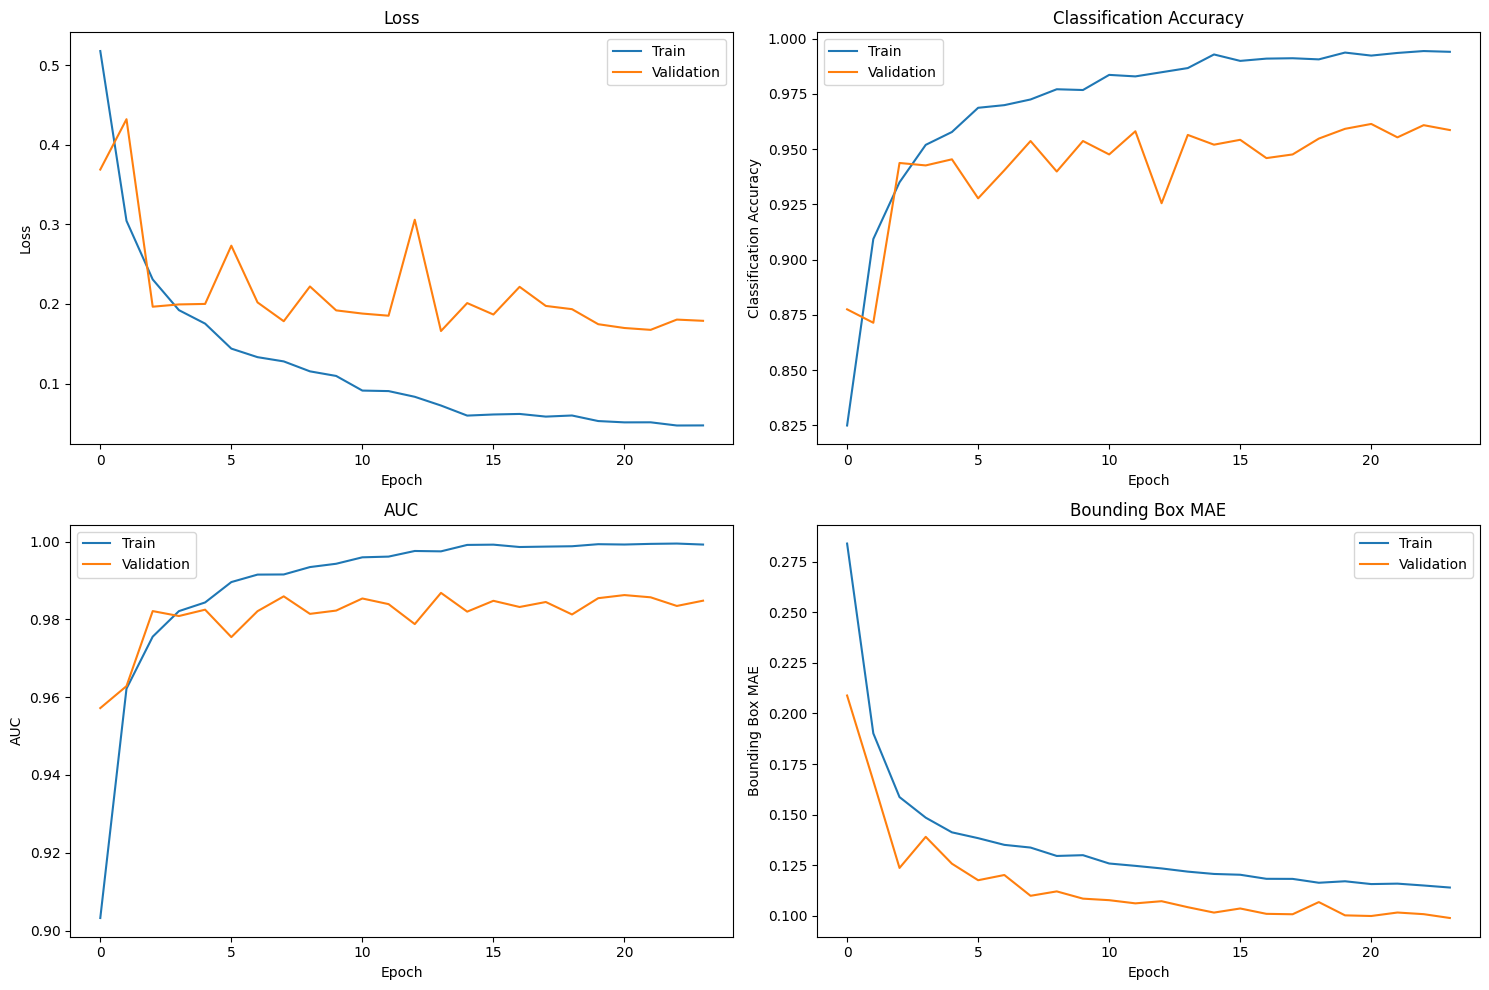

In [8]:
model, history, data_processor, experiment_dir = train_model(
        base_path='dataset/',
        batch_size=32,
        epochs=100,
        initial_learning_rate=0.0001,
        min_learning_rate=1e-6,
        patience=10,
        confidence_threshold=0.5
    )

In [103]:
from tensorflow.keras.models import load_model

best_model_path = sorted(list((experiment_dir / 'models').glob('model-*.keras')))[-1]
model = load_model(best_model_path)

In [78]:
test_dataset = data_processor.create_dataset(
    os.path.join('dataset', 'test', '_annotations.csv'),
    os.path.join('dataset', 'test'),
    is_training=False
)

# Evaluate model on the test dataset
results = model.evaluate(test_dataset)
(test_loss, 
 class_output_loss, 
 bbox_output_loss,
 test_accuracy,
 class_output_accuracy,
 class_output_precision,
 class_output_recall,
 class_output_auc,
 bbox_output_mae) = results

# Print the metrics
print(f'Test Loss: {test_loss}')
print(f'Class Output Loss: {class_output_loss}')
print(f'Bounding Box Output Loss: {bbox_output_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Class Output Accuracy: {class_output_accuracy}')
print(f'Class Output Precision: {class_output_precision}')
print(f'Class Output Recall: {class_output_recall}')
print(f'Class Output AUC: {class_output_auc}')
print(f'Bounding Box MAE: {bbox_output_mae}')

y_pred = model.predict(test_dataset)
print(y_pred)


28/28 [==============================] - 58s 2s/step - loss: 0.1979 - class_output_loss: 0.1736 - bbox_output_loss: 0.0121 - class_output_accuracy: 0.9505 - class_output_auc: 0.9805 - class_output_precision: 0.9784 - class_output_recall: 0.9548 - bbox_output_mae: 0.1135 - bbox_output_mean_squared_error: 0.0243
Test Loss: 0.1978713423013687
Class Output Loss: 0.17360755801200867
Bounding Box Output Loss: 0.012131879106163979
Test Accuracy: 0.9504504799842834
Class Output Accuracy: 0.9805161356925964
Class Output Precision: 0.9783616662025452
Class Output Recall: 0.9547511339187622
Class Output AUC: 0.11352655291557312
Bounding Box MAE: 0.024263758212327957
28/28 [==============================] - 66s 2s/step
[array([[3.17628183e-05],
       [9.99821424e-01],
       [9.99333680e-01],
       [9.99820054e-01],
       [9.99999404e-01],
       [7.49764085e-01],
       [1.83478799e-02],
       [9.99955893e-01],
       [9.98756170e-01],
       [9.98474360e-01],
       [9.99945879e-01],
       

28/28 [==============================] - 74s 3s/step
Classification Report:
              precision    recall  f1-score   support

         gun       1.00      1.00      1.00       888

    accuracy                           1.00       888
   macro avg       1.00      1.00      1.00       888
weighted avg       1.00      1.00      1.00       888



d:\testing\.testenv\Lib\site-packages\sklearn\metrics\_classification.py:2642: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(
d:\testing\.testenv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


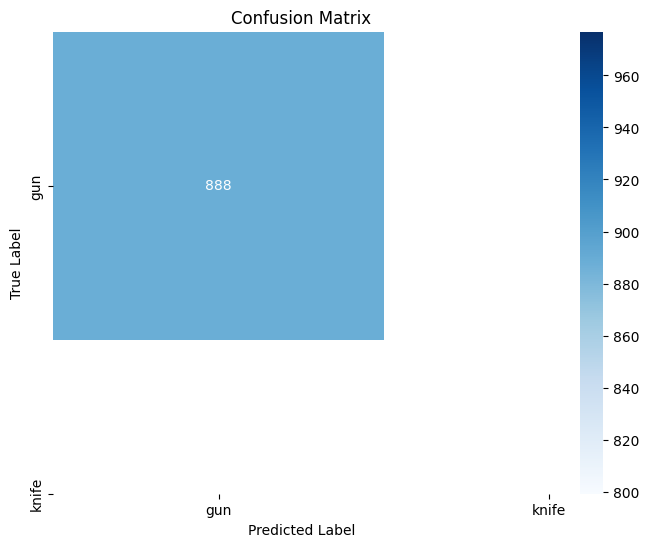

In [80]:
class_pred, bbox_pred = model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)

# Extract true class labels from test dataset
true_class_labels = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))
true_class_labels = np.array(true_class_labels)

# Classification report
print("Classification Report:")
print(classification_report(true_class_labels, class_pred_labels, labels=np.unique(true_class_labels), target_names=sorted(data_processor.label_encoder.classes_)))

# Confusion Matrix
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels, labels=np.unique(true_class_labels))
plt.figure(figsize=(8, 6))
sorted_classes = sorted(data_processor.label_encoder.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# test code

In [82]:
def preprocess_image(image_path, target_size=(460, 460)):
    if isinstance(image_path, (str, Path)):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image_path
        
    # Resize image
    image = cv2.resize(image, target_size)
    
    # Normalize pixel values
    image = image.astype(np.float32) / 255.0
    
    return image

def draw_prediction(image, result, threshold):

    height, width = image.shape[:2]
    
    # Convert bbox from normalized coordinates to pixel coordinates
    bbox = result['bbox']
    x1 = int(bbox[0] * width)
    y1 = int(bbox[1] * height)
    x2 = int((bbox[0] + bbox[2]) * width)
    y2 = int((bbox[1] + bbox[3]) * height)
    
    # Choose color based on prediction (green for no weapon, red for weapon)
    color = (0, 255, 0) if result['prediction'] == 'no_weapon' else (255, 0, 0)
    
    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    
    # Add text with confidence
    text = f"{result['prediction']}: {result['confidence']:.2f}"
    cv2.putText(image, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    return image

def test_single_image(model, image_path, threshold=0.5, display=True):
    
    # Read and preprocess image
    original_image = cv2.imread(str(image_path))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    processed_image = preprocess_image(image_path)
    
    # Get prediction
    result = model.predict_with_threshold(np.expand_dims(processed_image, axis=0), threshold=threshold)
    
    if display:
        # Draw prediction on image
        display_image = draw_prediction(original_image.copy(), result, threshold)
        
        # Display results
        plt.figure(figsize=(12, 8))
        plt.imshow(display_image)
        plt.title(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
        plt.axis('off')
        plt.show()
    
    return result

def test_directory(model, directory_path, threshold=0.5, save_results=True, output_dir='results'):
    
    directory_path = Path(directory_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Get all image files
    image_files = list(directory_path.glob('*.jpg')) + list(directory_path.glob('*.png'))
    results = []
    
    for image_path in image_files:
        print(f"Processing {image_path.name}...")
        
        # Read and preprocess image
        original_image = cv2.imread(str(image_path))
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        processed_image = preprocess_image(image_path)
        
        # Get prediction
        result = model.predict_with_threshold(np.expand_dims(processed_image, axis=0), threshold=threshold)
        result['image_name'] = image_path.name
        results.append(result)
        
        if save_results:
            # Draw prediction on image
            annotated_image = draw_prediction(original_image.copy(), result, threshold)
            
            # Save annotated image
            output_path = output_dir / f"pred_{image_path.name}"
            plt.figure(figsize=(12, 8))
            plt.imshow(annotated_image)
            plt.title(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
            plt.axis('off')
            plt.savefig(output_path)
            plt.close()
    
    return results

1/1 [==============================] - 1s 763ms/step


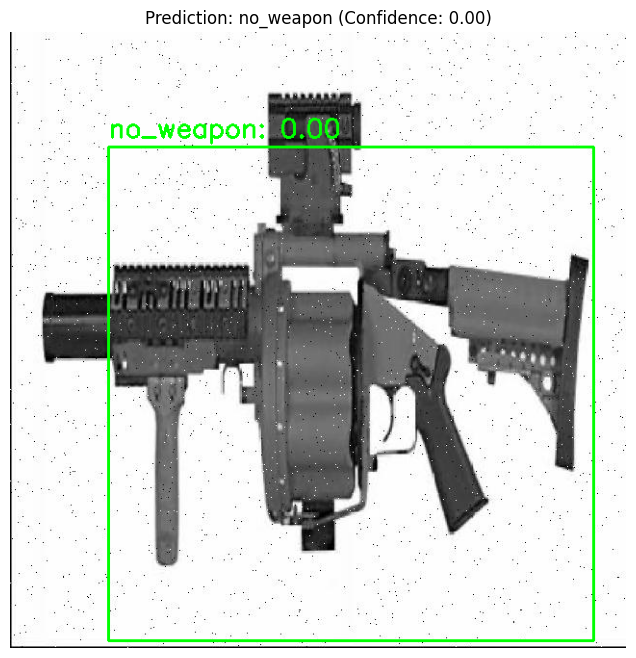


Test prediction: no_weapon
Confidence: 0.00


In [111]:
model = VisionModel(num_classes=2, confidence_threshold=0.5)
model.model.load_weights(best_model_path)

test_image_path = 'try/Grenade-Launcher_3_jpeg_jpg.rf.6b130f0c52b250fce7561aaae1f7cb70.jpg'
if os.path.exists(test_image_path):
    result = test_single_image(model, test_image_path)
    print(f"\nTest prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}")


In [106]:
# Load your trained model
model = VisionModel(num_classes=2, confidence_threshold=0.5)
model.model.load_weights(best_model_path)
    
# Test single image
# image_path = 'path_to_test_image.jpg'
# result = test_single_image(model, image_path, threshold=0.7)
# print(f"Single image result: {result}")
    
# Test directory of images
test_dir = 'dataset/test/'
results = test_directory(model, test_dir, threshold=0.5)
    
# Print summary of results
weapon_count = sum(1 for r in results if r['prediction'] == 'weapon')
total_count = len(results)
print(f"\nResults Summary:")
print(f"Total images processed: {total_count}")
print(f"Weapons detected: {weapon_count}")
print(f"No weapons detected: {total_count - weapon_count}")
    
# Print detailed results
print("\nDetailed Results:")
for result in results:
    print(f"Image: {result['image_name']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}")
    print("---")

Processing -0_jpg.rf.eecfb0dca2432f9d688bfcd064b9559b.jpg...
1/1 [==============================] - 0s 413ms/step
Processing -101_jpg.rf.b86e5b76eac2ea244d2242bad5af0f7f.jpg...
1/1 [==============================] - 0s 185ms/step
Processing -160_jpg.rf.cceb168abac4ae19814164655468b06b.jpg...
1/1 [==============================] - 0s 183ms/step
Processing -165_jpg.rf.77c960b6ecbb29ae051abb1ffdfdd014.jpg...
1/1 [==============================] - 0s 182ms/step
Processing -225_jpg.rf.ef7a4bc202f7e1c7da051c463ac24f1b.jpg...
1/1 [==============================] - 0s 181ms/step
Processing -23_jpg.rf.22d1adb34f46e49cc4e9dea37070adcb.jpg...
1/1 [==============================] - 0s 179ms/step
Processing -281_jpg.rf.d26e04320ea9e8a5fdc7f826d14afd5b.jpg...
1/1 [==============================] - 0s 160ms/step
Processing -287_jpg.rf.4425864d3b3308afb9f60596d300be6e.jpg...
1/1 [==============================] - 0s 178ms/step
Processing -299_jpg.rf.7e26236ae2814d469153f4ccf41733cf.jpg...
1/1 [=======

In [105]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None):
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    
    height, width = image.shape[:2]

    if pred_boxes is not None:
        box = pred_boxes[0]  
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, 
                                        color='red', 
                                        linewidth=2,
                                        label='Predicted'))
    
    if true_boxes is not None:
        box = true_boxes[0]  
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, 
                                        color='green', 
                                        linewidth=2,
                                        label='Ground Truth'))
    
    plt.legend()
    plt.axis('on')
    plt.tight_layout()
    plt.show()

test_dataset_iter = iter(test_dataset)  
batch = next(test_dataset_iter)  

image = batch[0][0].numpy()  
true_boxes = batch[1]['bbox_output'][0].numpy()  

pred_boxes = model.predict(image[np.newaxis, ...])[1][0]  
print("Predicted boxes shape:", pred_boxes.shape)
print("True boxes shape:", true_boxes.shape)
print("Image shape:", image.shape)

num_images = 5 
for i, batch in enumerate(test_dataset.take(num_images)):
    
    image = batch[0][0].numpy()
    true_boxes = batch[1]['bbox_output'][0].numpy()
    
    pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
    
    plot_image_with_boxes(image, [pred_boxes], [true_boxes])
    
    if i >= num_images - 1:
        break  

AttributeError: 'VisionModel' object has no attribute 'predict'

# single object plot bbox

1/1 [==============================] - 0s 208ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.041614473..1.0095963].


1/1 [==============================] - 0s 215ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11579305..1.1872262].


1/1 [==============================] - 0s 276ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07740554..0.88746035].


1/1 [==============================] - 0s 266ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06268658..1.2533681].


1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14797896..0.80208087].


1/1 [==============================] - 0s 183ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008895404..1.1002011].


1/1 [==============================] - 0s 201ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.088122666..1.2444134].


1/1 [==============================] - 0s 173ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14986992..0.9364256].


1/1 [==============================] - 0s 149ms/step


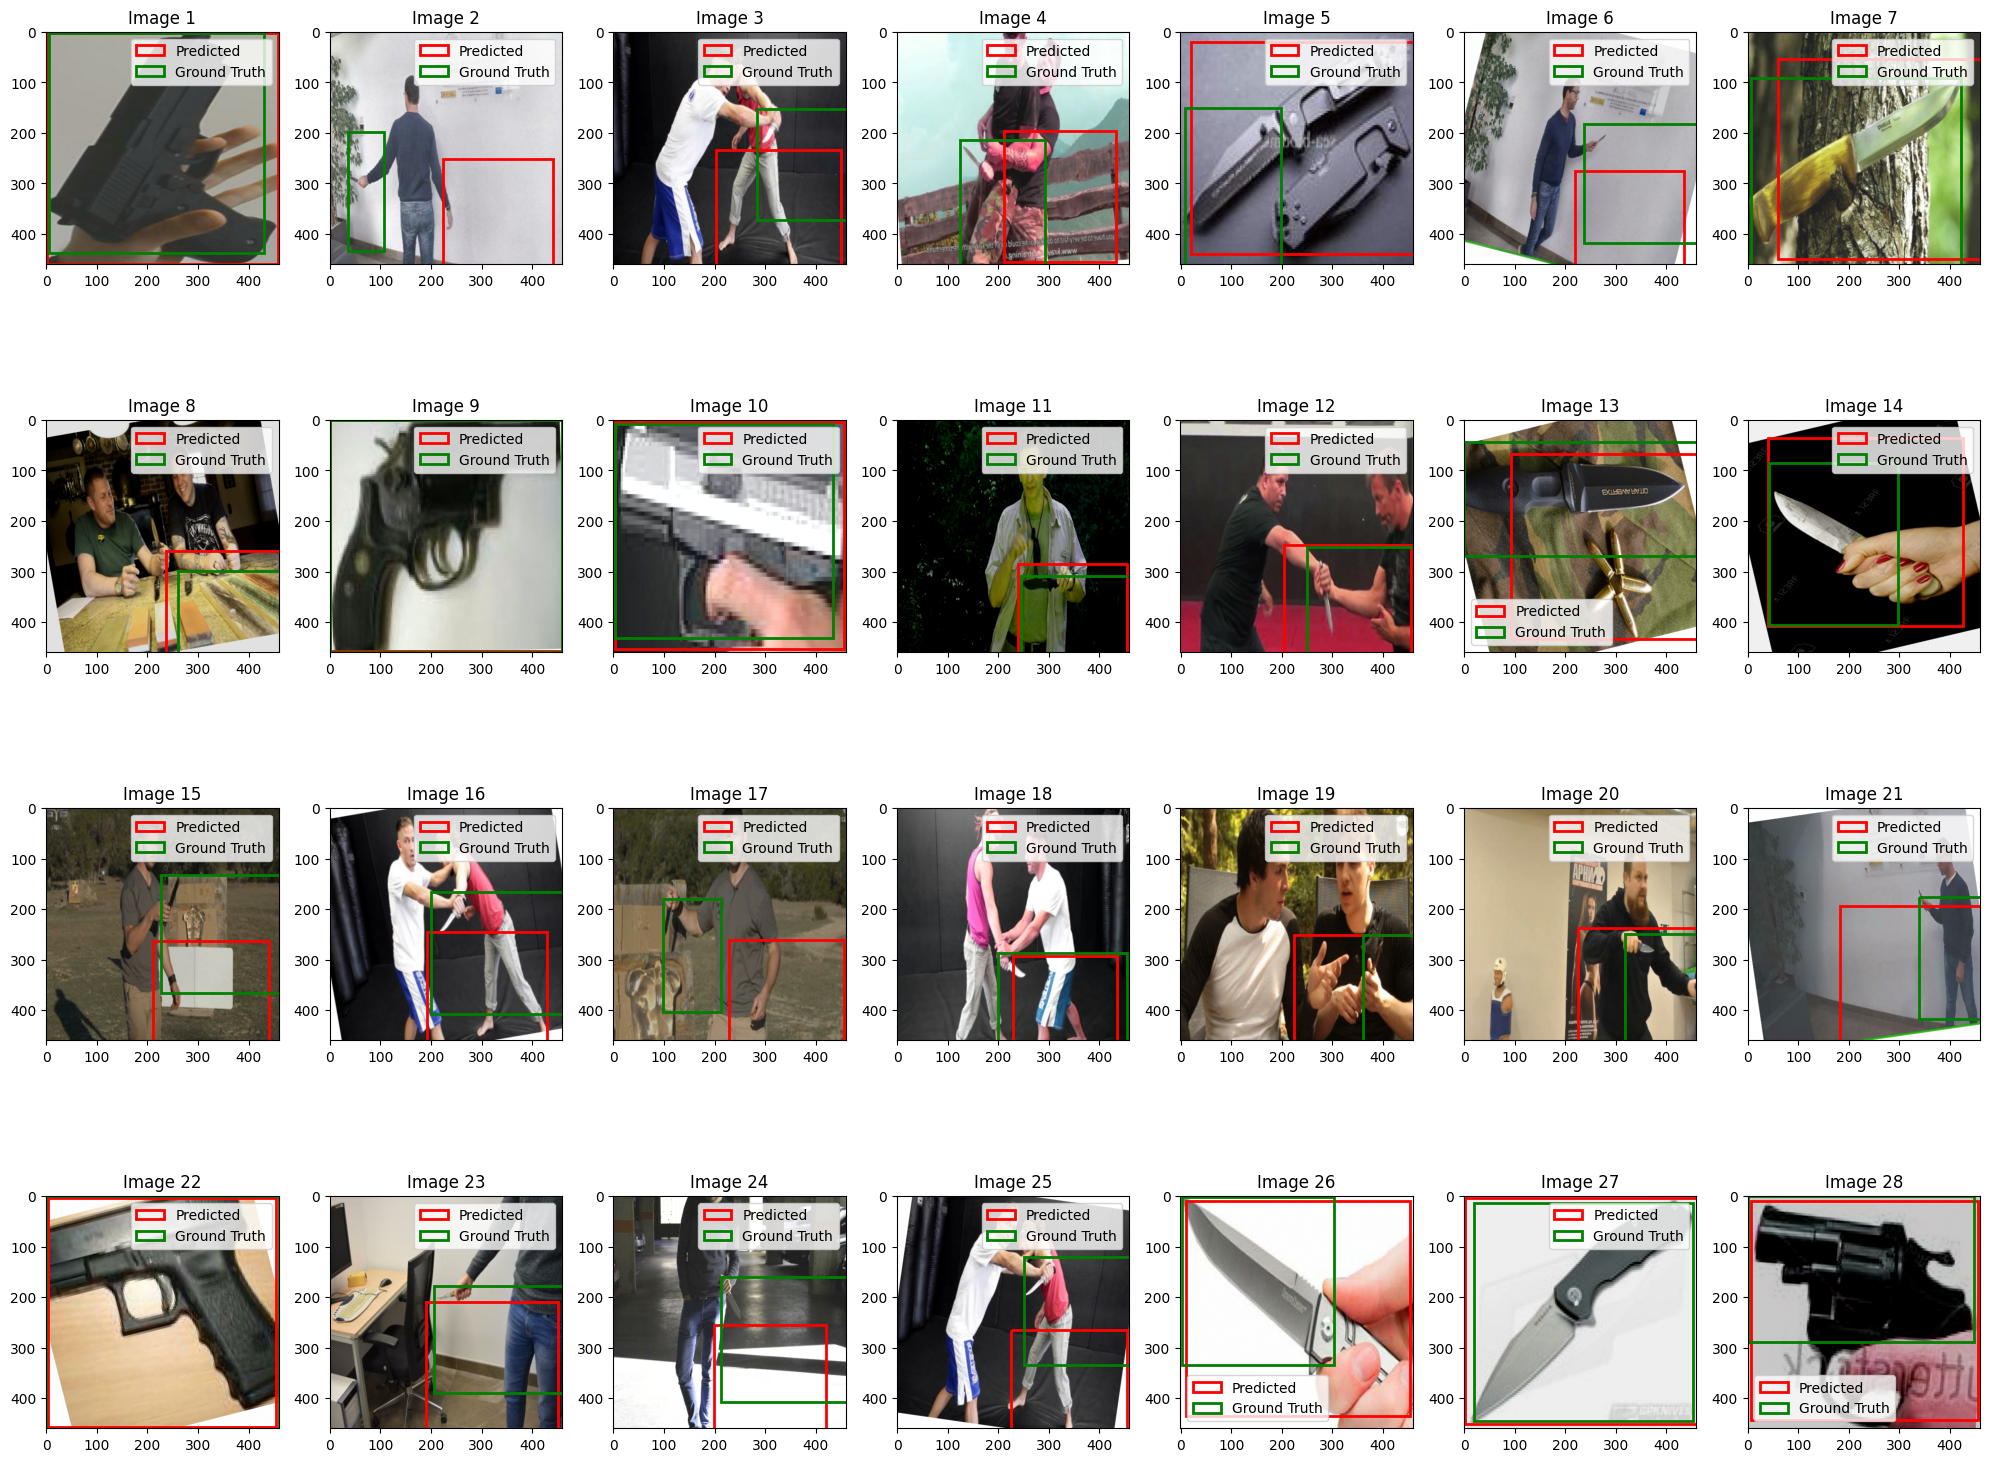

In [40]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(image, cmap='gray')
    
    height, width = image.shape[:2]
    
    if pred_boxes is not None:
        box = pred_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='red', 
                                 linewidth=2,
                                 label='Predicted'))
    
    if true_boxes is not None:
        box = true_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='green', 
                                 linewidth=2,
                                 label='Ground Truth'))
    
    ax.legend()

def plot_multiple_images(test_dataset, num_images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    axes = axes.ravel() 
    
    for i, batch in enumerate(test_dataset.take(num_images)):
        if i >= num_images:
            break
            
        image = batch[0][0].numpy()
        true_boxes = batch[1]['bbox_output'][0].numpy()
        
        pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
        
        plot_image_with_boxes(image, [pred_boxes], [true_boxes], ax=axes[i])
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

num_images = 28
rows = 4      
cols = 7        

plot_multiple_images(test_dataset, num_images, rows, cols)

1/1 [==============================] - 1s 527ms/step


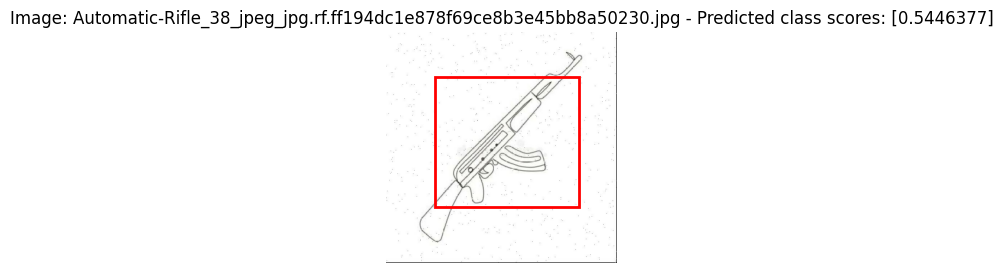

1/1 [==============================] - 0s 136ms/step


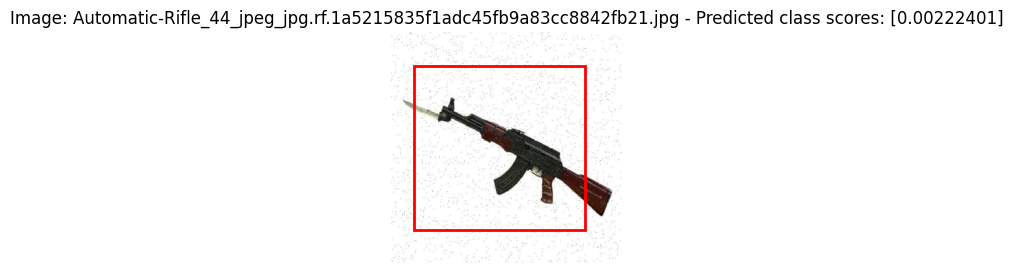

1/1 [==============================] - 0s 136ms/step


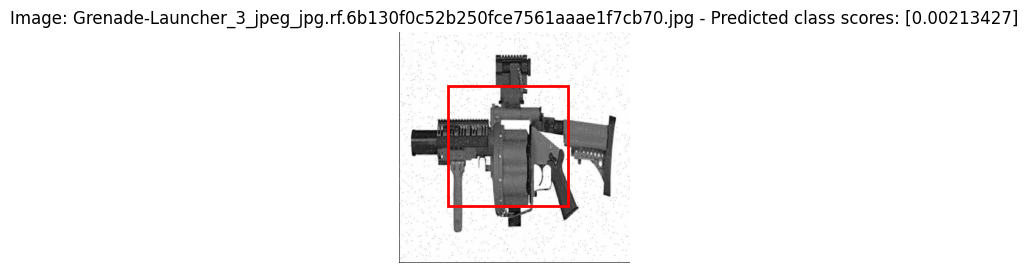

1/1 [==============================] - 0s 129ms/step


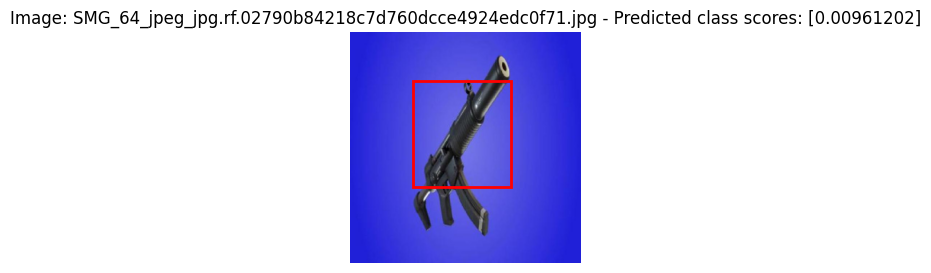

In [66]:
from tensorflow.keras.preprocessing import image as keras_image

def preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=model.input_shape[1:3])
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def plot_image_with_boxes(img_array, boxes):
    plt.imshow(img_array)
    img_height, img_width = img_array.shape[:2]
    for box in boxes:
        # Check if box values are normalized, and scale them if necessary
        xmin, ymin, xmax, ymax = box
        if xmin < 1 and ymin < 1 and xmax < 1 and ymax < 1:  # Assume normalized if values < 1
            xmin, xmax = xmin * img_width, xmax * img_width
            ymin, ymax = ymin * img_height, ymax * img_height

        # Plot bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', linewidth=2, fill=False))
    plt.axis('off')

def test_model_on_folder(folder_path, model, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    for i, img_file in enumerate(image_files[:num_images]):
        img_path = os.path.join(folder_path, img_file)
        img_array = preprocess_image(img_path)

        # Get predictions
        predictions = model.predict(img_array)
        pred_classes = predictions[0][0]   # Assuming class_output is the first in the list
        pred_boxes = predictions[1][0]     # Assuming bbox_output is the second in the list

        # Display image with predicted boxes
        img = keras_image.load_img(img_path)
        plt.figure(figsize=(3, 3))
        plot_image_with_boxes(np.array(img), [pred_boxes])
        plt.title(f"Image: {img_file} - Predicted class scores: {pred_classes}")
        plt.show()

        if i >= num_images - 1:
            break

# Test the model on images in a new folder
folder_path = 'try/'  # Specify the path to your new folder
test_model_on_folder(folder_path, model, num_images=4)